## Import libs

In [1]:
import json
import nltk
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
import gc
from torch.utils.data import Dataset, DataLoader
from insights import load_data, extract_data, get_insights, plot_histogram, plot_bar_chart
from preprocessing import preprocess_with_stopwords_with_lemmatization, preprocess_without_stopwords_with_lemmatization, preprocess_with_stopwords_without_lemmatization, preprocess_without_stopwords_without_lemmatization
from classification import train_and_evaluate_nb, train_and_evaluate_ffnn, load_json_data, prepare_train_test_split, move_samples_between_sets

## Task 1: Extract insights from data

                                                text    category
0  THIS IS MASSIVE Australian Senator Malcolm Rob...  CONSPIRACY
1  “ I ’m deeply concerned that the push to vacci...    CRITICAL
2  2021 : They wanted to know your vaccination st...    CRITICAL
3  Anthony Fauci once again defended brutal Chine...    CRITICAL
4  Proof has emerged showing that death from Wuha...    CRITICAL


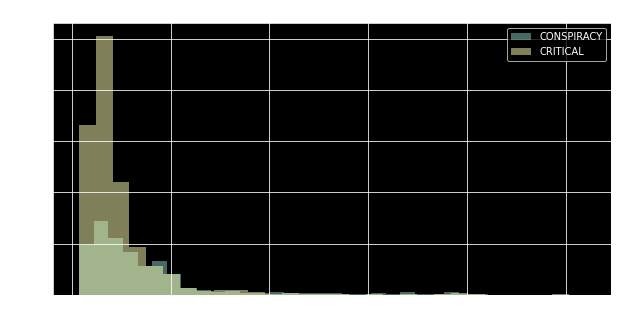

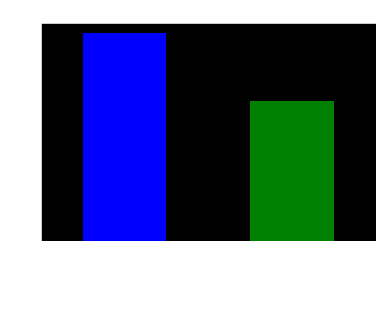

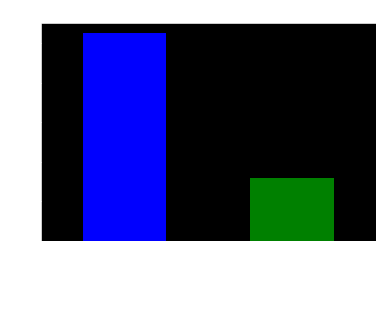

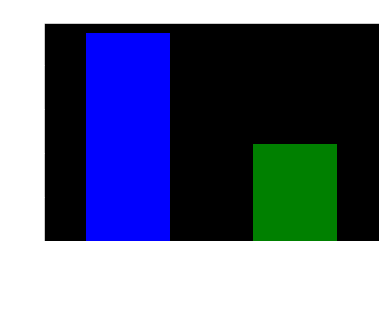

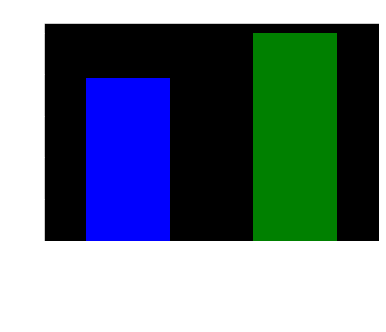

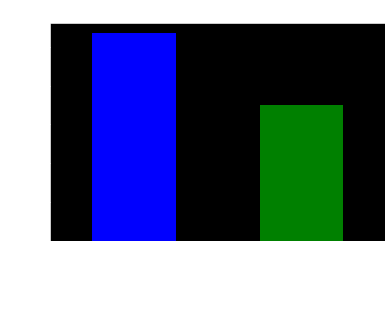

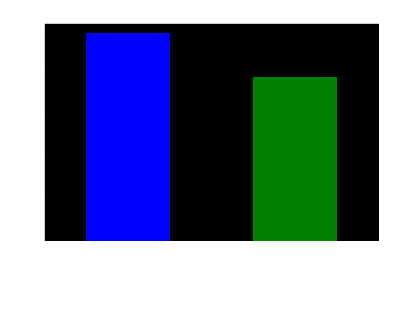

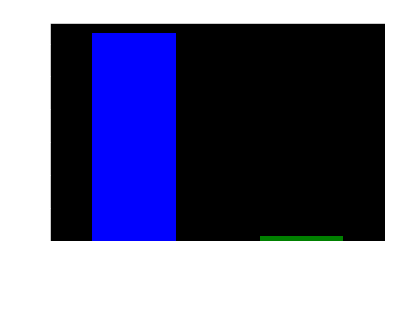

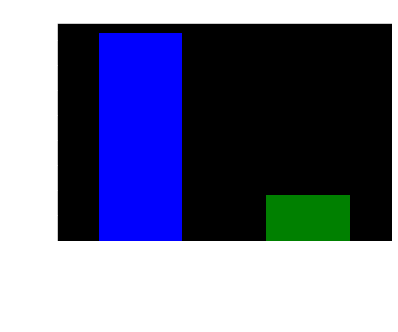

In [3]:
# Load and extract data
data = load_data('data/Oppositional_thinking_analysis_dataset.json')

# Extract text and category from the data.
data_extracted = extract_data(data)

# Convert to DataFrame
df = pd.DataFrame(data_extracted)
print(df.head())

# Adding new features
df = get_insights(df)

# Plot distributions and bar charts. (df, category, title, xlabel, ylabel):
plot_histogram(df, 'text_length', 'Text Length Distribution by Category', 'Number of Words', 'Frequency')
plot_bar_chart(df, 'unique_word_count', 'Average Number of Unique Words by Category', 'Average Unique Words')
plot_bar_chart(df, 'uppercase_word_count', 'Average Number of Uppercase Words by Category', 'Average Uppercase Words')
plot_bar_chart(df, 'exclamation_count', 'Average Number of Exclamation Marks by Category', 'Average Exclamation Marks')

# Plot feature-based bar charts
plot_bar_chart(df, 'contains_link', 'Proportion of Texts Containing Links by Category', 'Proportion Containing Links')
plot_bar_chart(df, 'contains_parentheses', 'Proportion of Texts Containing Parentheses by Category', 'Proportion Containing Parentheses')
plot_bar_chart(df, 'contains_quotation_marks', 'Proportion of Texts Containing Quotation Marks by Category', 'Proportion Containing Quotation Marks')
plot_bar_chart(df, 'contains_5G', 'Proportion of Texts Containing "5G" or "5 G" by Category', 'Proportion Containing "5G" or "5 G"')
plot_bar_chart(df, 'contains_bill_gates', 'Proportion of Texts Containing "Bill Gates" by Category', 'Proportion Containing "Bill Gates"')

## Task 2: Pre-processing

### Load the input text file and extract texts and labels

In [4]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

with open('data/Oppositional_thinking_analysis_dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract text and category
data_extracted = [{'text': entry['text'], 'category': entry['category']} for entry in data]

category_mapping = {
    'CRITICAL': 0,     
    'CONSPIRACY': 1
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitrijschulz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitrijschulz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Preprocess the input texts in different ways and save each example in a json file

In [5]:
# 3 min
def preprocess_and_save(data, preprocess_func, file_name):
    df = pd.DataFrame(data)
    df['preprocessed_text'] = df['text'].apply(preprocess_func)
    df = df.drop('text', axis=1)
    df['category'] = df['category'].apply(lambda x: category_mapping[x])
    df.to_json(file_name, orient='records', lines=True, force_ascii=False)
    print(df.head())
    return df

# List of preprocessing configurations
preprocessing_configs = [
    ('preprocess_with_stopwords_with_lemmatization', preprocess_with_stopwords_with_lemmatization, 'data/preprocess_with_stopwords_with_lemmatization.json'),
    ('preprocess_without_stopwords_with_lemmatization', preprocess_without_stopwords_with_lemmatization, 'data/preprocess_without_stopwords_with_lemmatization.json'),
    ('preprocess_with_stopwords_without_lemmatization', preprocess_with_stopwords_without_lemmatization, 'data/preprocess_with_stopwords_without_lemmatization.json'),
    ('preprocess_without_stopwords_without_lemmatization', preprocess_without_stopwords_without_lemmatization, 'data/preprocess_without_stopwords_without_lemmatization.json')
]

# Dictionary to store preprocessed DataFrames
preprocessed_data = {}

# Apply preprocessing and save results
for name, func, file_name in preprocessing_configs:
    preprocessed_data[name] = preprocess_and_save(data_extracted, func, file_name)

   category                                  preprocessed_text
0         1  this is massive australian senator malcolm rob...
1         0  i m deeply concerned that the push to vaccinat...
2         0  two thousand and twentyone they wanted to know...
3         0  anthony fauci once again defended brutal chine...
4         0  proof ha emerged showing that death from wuhan...
   category                                  preprocessed_text
0         1  massive australian senator malcolm robert expo...
1         0  deeply concerned push vaccinate child nothing ...
2         0  two thousand twentyone wanted know vaccination...
3         0  anthony fauci defended brutal chinese lockdown...
4         0  proof emerged showing death wuhan coronavirus ...
   category                                  preprocessed_text
0         1  this is massive australian senator malcolm rob...
1         0  i m deeply concerned that the push to vaccinat...
2         0  two thousand and twentyone they wanted to 

## Task 3: Vectorization and Text classification

### Load data with different pre-processing steps

In [6]:
# Load the preprocessed JSON data (from Task 2)
data_files = [
    'data/preprocess_with_stopwords_with_lemmatization.json',
    'data/preprocess_without_stopwords_with_lemmatization.json',
    'data/preprocess_with_stopwords_without_lemmatization.json',
    'data/preprocess_without_stopwords_without_lemmatization.json'
]

### Define different vectorization Models

In [7]:
# Vectorizers to compare
vectorizers = [
    (TfidfVectorizer(ngram_range=(1, 1)), 'TfidfVectorizer1'),
    (TfidfVectorizer(ngram_range=(2, 2)), 'TfidfVectorizer2'),
    (TfidfVectorizer(ngram_range=(3, 3)), 'TfidfVectorizer3'),
    (CountVectorizer(ngram_range=(1, 1)), 'CountVectorizer1'), # Unigrams
    (CountVectorizer(ngram_range=(2, 2)), 'CountVectorizer2'), # Bigrams
    (CountVectorizer(ngram_range=(3, 3)), 'CountVectorizer3'),  # Trigrams
]

### Naïve Bayes Model with different vectorizers and pre-processing steps

#### Train Naïve Bayes Model

In [14]:
# Initialize dictionaries to store results and misclassifications
results = {}
misclassifications = {}
nb_res_path = "data/nb_results/"
os.makedirs(nb_res_path, exist_ok=True)

# Iterate over each data file and each vectorizer
for data_file in data_files:
    # Load data
    data = load_json_data(data_file)
    
    # Prepare train and test sets
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "nb")
    print(100*"-")
    print(f"\nData file: {data_file}")
    print("Original train set length:", len(X_train))
    print("Original test set length:", len(X_test))
    
    # Move samples of the 'CRITICAL' category (labeled as 0)
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    
    print("\nAfter undersampling:")
    print("Train set length:", len(X_train))
    print("Test set length:", len(X_test))
    print("Train and test sets loaded for preprocessed data file. Training with this preprocessed file:\n")
    # Dictionary to store classification reports and misclassification info
    results[data_file] = {}
    misclassifications[data_file] = {}

    # Remove 'data/' prefix from data_file
    file_name_without_data = data_file.replace('data/', '')

    # Iterate over each vectorizer for this data file
    for vectorizer, vectorizer_name in vectorizers:
        report, misclassified_data_nb, misclassified_count, total = train_and_evaluate_nb(vectorizer, X_train['preprocessed_text'], X_test['preprocessed_text'], y_train, y_test, data_file, vectorizer_name)
        results[data_file][vectorizer_name] = report
        misclassifications[data_file][vectorizer_name] = (misclassified_count, total)
        # Save misclassified examples to JSON file
        with open(f"{nb_res_path}{file_name_without_data}_{vectorizer_name}_misclassified.json", 'w') as f:
            json.dump(misclassified_data_nb, f, indent=4)


----------------------------------------------------------------------------------------------------

Data file: data/preprocess_with_stopwords_with_lemmatization.json
Original train set length: 3200
Original test set length: 800

After undersampling:
Train set length: 2450
Test set length: 1550
Train and test sets loaded for preprocessed data file. Training with this preprocessed file:

Vectorizer: TfidfVectorizer1


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1274
           1       0.69      0.72      0.71       276

    accuracy                           0.89      1550
   macro avg       0.82      0.82      0.82      1550
weighted avg       0.89      0.89      0.89      1550

Number of misclassified examples out of 1550 examples : 165
**************************************************
Vectorizer: TfidfVectorizer2


Classification Report:
              precision    recall  f1-score   support

        

#### Visualize Statistics for Bayes

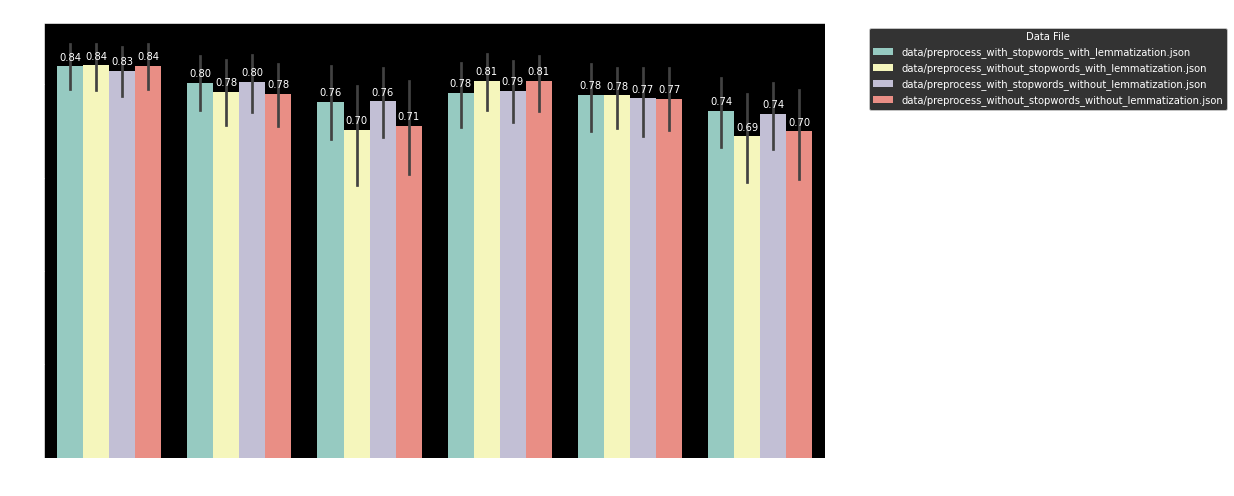

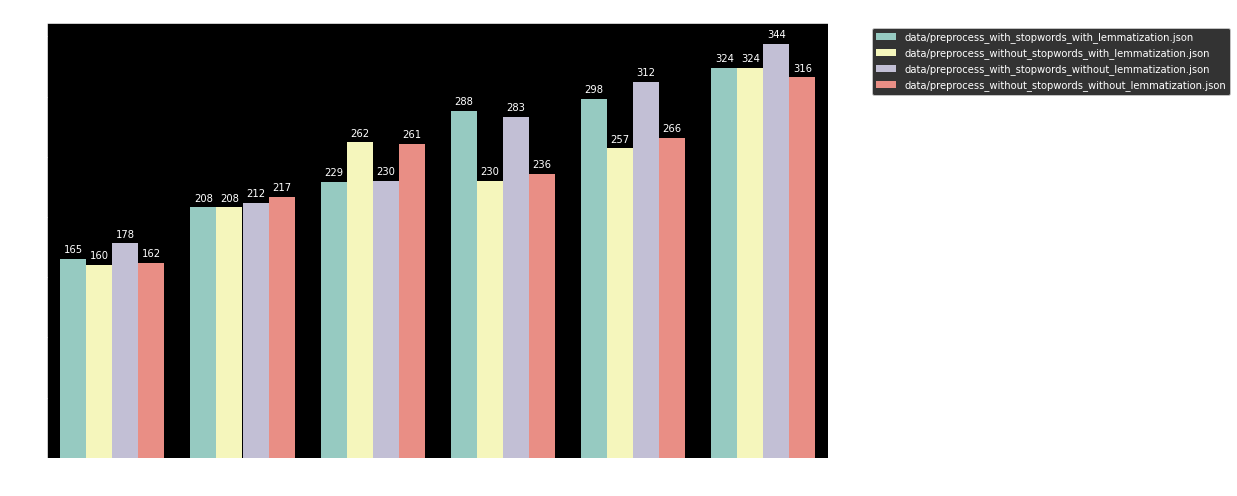

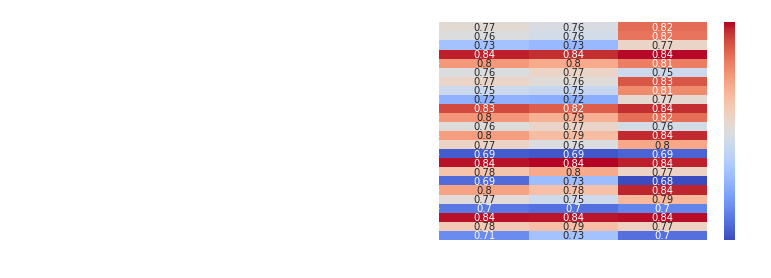

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to a DataFrame for visualization
def results_to_dataframe(results):
    records = []
    for data_file, vectorizer_reports in results.items():
        for vectorizer_name, report in vectorizer_reports.items():
            for metric in ['precision', 'recall', 'f1-score']:
                for label, scores in report.items():
                    if isinstance(scores, dict):
                        records.append({
                            'Data File': data_file,
                            'Vectorizer': vectorizer_name,
                            'Label': label,
                            'Metric': metric,
                            'Score': scores[metric]
                        })
    return pd.DataFrame(records)

# Create DataFrame from results
df_results = results_to_dataframe(results)

# Create a DataFrame for misclassifications
misclass_records = []
for data_file, vectorizer_data in misclassifications.items():
    for vectorizer_name, (misclassified, total) in vectorizer_data.items():
        misclass_records.append({
            'Data File': data_file,
            'Vectorizer': vectorizer_name,
            'Misclassified': misclassified,
            'Total': total
        })
df_misclassifications = pd.DataFrame(misclass_records)

# Plotting the scores
plt.figure(figsize=(14, 8))
score_plot = sns.barplot(x='Vectorizer', y='Score', hue='Data File', data=df_results)

# Annotate bars with score values
for p in score_plot.patches:
    score_plot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

plt.title('Scores Comparison per Vectorizer and Data File')
plt.xlabel('Vectorizer')
plt.ylabel('Score')
plt.legend(title='Data File', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Plotting the misclassifications (unchanged from previous code)
plt.figure(figsize=(14, 8))
misclass_plot = sns.barplot(x='Vectorizer', y='Misclassified', hue='Data File', data=df_misclassifications)

# Annotate bars with misclassification values
for p in misclass_plot.patches:
    misclass_plot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', 
                           xytext=(0, 9), 
                           textcoords='offset points')

plt.title('Number of Misclassifications per Vectorizer and Data File')
plt.xlabel('Vectorizer')
plt.ylabel('Number of Misclassifications')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Additional visualization example: Heatmap (unchanged from previous code)
pivot_table = df_results.pivot_table(values='Score', index=['Data File', 'Vectorizer'], columns='Metric')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Vectorizer Performance')
plt.show();

#### Error analysis

In [ ]:
# REPORT

### FFNN Model

##### Define Hyperparameters and FFNN

In [4]:
# Hyperparameters
#input_size = 0  # vectorizers output
hidden_size1 = 64
hidden_size2 = 32
output_size = 1
dropout_rate = 0.4
learning_rate = 0.001
batch_size = 32
epochs = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.float32)

    
# FFNN Model class
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


##### Train and evaluate FFNN Models

In [5]:
torch.cuda.empty_cache()
gc.collect()

# Iterate over each data file and each vectorizer
for data_file in data_files:
    data = load_json_data(data_file)
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "ffnn")
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    print(100*"-")
    for vectorizer, vectorizer_name in vectorizers:
        vectorizer.fit(X_train)  # Fit the vectorizer only on training data
        X_train_vec = vectorizer.transform(X_train).toarray()
        X_test_vec = vectorizer.transform(X_test).toarray()
        
        # Create datasets and dataloaders
        train_dataset = TextDataset(X_train_vec, y_train.values)
        test_dataset = TextDataset(X_test_vec, y_test.values)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(f"\nData file: {data_file} | Vectorizer: {vectorizer_name}")
        
        # Initialize model, criterion, and optimizer
        model = FFNN(input_size=X_train_vec.shape[1],
                     hidden_size1=hidden_size1,
                     hidden_size2=hidden_size2,
                     output_size=output_size,
                     dropout_rate=dropout_rate).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train and evaluate FFNN model
        train_and_evaluate_ffnn(model, train_loader, test_loader, criterion, optimizer, device, epochs)

----------------------------------------------------------------------------------------------------

Data file: data/preprocess_with_stopwords_with_lemmatization.json | Vectorizer: TfidfVectorizer1
F1 Score: 0.6458
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      1274
         1.0       0.53      0.82      0.65       276

    accuracy                           0.84      1550
   macro avg       0.74      0.83      0.77      1550
weighted avg       0.88      0.84      0.85      1550


Number of misclassified examples out of 1550 examples: 249

Data file: data/preprocess_with_stopwords_with_lemmatization.json | Vectorizer: TfidfVectorizer2
F1 Score: 0.6162
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      1274
         1.0       0.49      0.84      0.62       276

    accuracy                           0.81      1550
   macro avg       0.72      0.82      0.75      1550
weighted a

##### Error Analysis

In [ ]:
# REPORT

## Task 4: Textual similarity

In [ ]:
import random
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import normalize
from math import sqrt

# Provided sentences
sentences = [
{"category":0,"preprocessed_text":"coronavirus death joe biden first ten month office surpass death toll trump"},
{"category":0,"preprocessed_text":"nolte bidensanity unvaccinated illegal alien shipped dozen state coronavirus fear rage"},
{"category":1,"preprocessed_text":"new world order want people dead rest slave make sure dont child satanist want eat"},
{"category":0,"preprocessed_text":"exclusive govkristi noem joe biden rationing life saving coronavirus medicine political reason"},
{"category":0,"preprocessed_text":"short news clip alleged swine flu pandemic exaggerated position power maximise profit"},
{"category":0,"preprocessed_text":"postal worker union role federal government mandate vaccination"},
{"category":1,"preprocessed_text":"new world order ally uniparty want destroy united stateswe must let themstay alert keep head swivel"},
{"category":1,"preprocessed_text":"quote yetthere official definition long covid diagnostic criterion condition new zealand ministry health"},
{"category":0,"preprocessed_text":"report climate change pose threat much planetincluding american sovereignty"},
{"category":1,"preprocessed_text":"ukraine drama staged event like covid wasreal limited scale war blown proportion pub four"},
{"category":1,"preprocessed_text":"stanley plotkin admits use aborted baby vaccinesyou see contempt oozing jew ca nt youfull deposition"},
{"category":0,"preprocessed_text":"carlson america lost religion replaced cult coronavirus"},
{"category":0,"preprocessed_text":"greta thunberg biden admin ready act seriously need climate crisis"},
{"category":1,"preprocessed_text":"made take pig vaccine would think people would upset satanist resistance stop satan info saveusnoworguk"},
{"category":1,"preprocessed_text":"vaccine bio chemical weapon warn people got electron microscope image antenna contaminant want dead"}
]

# Extract preprocessed texts
texts = [sentence['preprocessed_text'] for sentence in sentences]

# Create a set of all unique words
unique_words = set(word for text in texts for word in text.split())

# Create a mapping of words to indices
word_index = {word: idx for idx, word in enumerate(unique_words)}

# Function to create one-hot encoded word vector
def word_vector(word, word_index, vocab_size):
    vector = np.zeros(vocab_size)
    if word in word_index:
        vector[word_index[word]] = 1
    return vector

# Function to compute average word vector for a sentence
def sentence_vector(sentence, word_index, vocab_size):
    words = sentence.split()
    word_vecs = [word_vector(word, word_index, vocab_size) for word in words]
    if not word_vecs:
        return np.zeros(vocab_size)
    return np.mean(word_vecs, axis=0)

# Vocabulary size
vocab_size = len(unique_words)

# Compute sentence vectors
sentence_vectors = [sentence_vector(text, word_index, vocab_size) for text in texts]

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)

# Compute cosine similarities
cosine_similarities = np.zeros((15, 15))
for i in range(15):
    for j in range(i + 1, 15):
        similarity = cosine_similarity(sentence_vectors[i], sentence_vectors[j])
        cosine_similarities[i, j] = similarity
        cosine_similarities[j, i] = similarity

# Report cosine similarities
for i in range(15):
    for j in range(i + 1, 15):
        print(f"Cosine similarity between sentence {i+1} and sentence {j+1}: {cosine_similarities[i, j]:.4f}")


### Bonus Task: Textual similarity